<div style="border: 1px solid #cce5ff; background-color: #e9f7fe; padding: 15px; border-radius: 6px; font-family: sans-serif;">
  <strong>🔹 GreenSurge</strong><br><br>

  The Hybrid Modeling of TC-induced Storm Surge surrogate model based on Green’s summation (GreenSurge) and inverse barometer methodology aims to produce accurate estimates of the wind setup and pressure-induced sea level changes due to tropical cyclones (TC) at regional-to-local scales.
</div>

<div style="border: 1px solid #cce5ff; background-color: #e9f7fe; padding: 15px; border-radius: 6px; font-family: sans-serif;">
  <strong>🔹 Methodology</strong><br><br>

  The steps followed by the GreenSurge methodology, which are exemplified in the figure below, can be summarized as folows:
  <ul>
    <li> Compilation of the Green’s functions database for the study area.</li>
    <li> Scaling and ensembled from the database to reconstruct any given TC and obtain the induced Wind Setup.</li>
    <li> Obtain the sea level changes due to pressure difference using inverse barometer .</li>
    <li> Obtain the storm surge as the sumation of Wind Set Up and Inverse Barometer .</li>
  <ul>
</div>

![Green Surge Diagram](assets/GS_scheme_Samoa.png)

# GreenSurge case setup script

## General parameters

### Names and paths

In [1]:
figsize = (7, 7)

In [2]:
import os

bathymetry_tif_raw_path = "inputs/Raster_singapur.tif"
base, ext = os.path.splitext(bathymetry_tif_raw_path)
output_bathy_clip_tif_path = f"{base}_clip{ext}"
clipped_raster_paths = [output_bathy_clip_tif_path]

site = "Singapur"

In [3]:
path_grd_calc = f"outputs/mesh_{site}_Calc_adcirc.grd"
path_grd_mesh = f"outputs/mesh_{site}_Mesh_adcirc.grd"

### General forcing parameters

In [4]:
from datetime import datetime

wind_speed = 40
direction_step = 15
simulation_duration_hours = 24
simulation_time_step_hours = 1
forcing_time_step = simulation_time_step_hours

reference_date = [2022, 1, 1, 0, 0, 0]
reference_date_dt = datetime(*reference_date)

Eddy = 10
Chezy = 70

### Limit wind effect depth

In [5]:
# Forcing Setup
forcing_cell_size = 50 * 1000
Wind_effect_max_depth = -100

Mean_Sea_Level = 0


In [6]:
from shapely.geometry import Point

point = Point(103.82165058293084, 1.3744749410187365)

## Raster preprocess

### Projection system for the mesh and bathymetry

In [7]:
import numpy as np
import pyproj

lon_center = np.mean(point.coords[0][0])
lat_center = np.mean(point.coords[0][1])

proj_str = (
    f"+proj=aeqd +lat_0={lat_center} +lon_0={lon_center} +units=m +datum=WGS84 +no_defs"
)
project = pyproj.Transformer.from_crs("EPSG:4326", proj_str, always_xy=True).transform

### Initial bathymetry raster

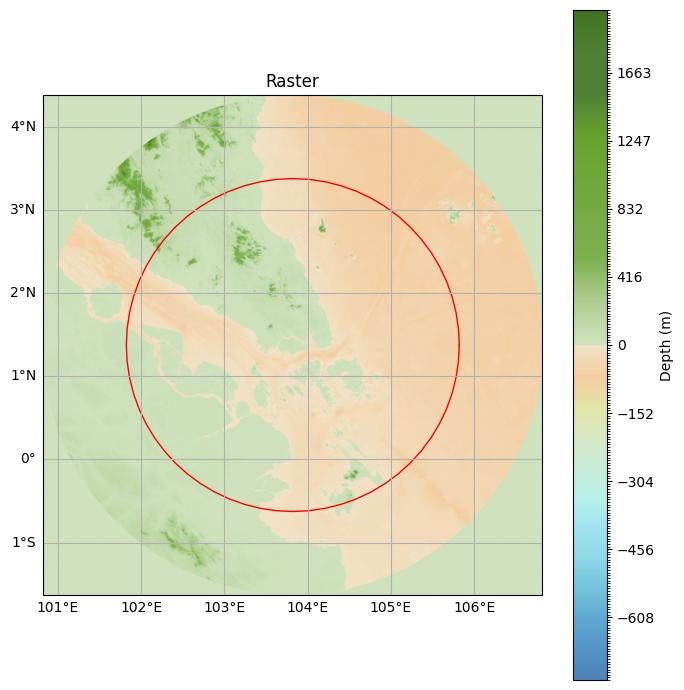

In [8]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from bluemath_tk.topo_bathy.mesh_utils import (
    get_raster_resolution,
    get_raster_resolution_meters,
    plot_bathymetry,
)
from pyproj import CRS
from shapely.geometry import Polygon

domain_crs = CRS.from_user_input("epsg:4326")
domain_polygon = Polygon(point.buffer(2).exterior.coords)

raster_resolution = get_raster_resolution(raster_path=output_bathy_clip_tif_path)
raster_resolution_meters = get_raster_resolution_meters(
    lon_center=lon_center,
    lat_center=lat_center,
    raster_resolution=raster_resolution,
    project=project,
)

fig, ax = plt.subplots(subplot_kw={"projection": ccrs.PlateCarree()}, figsize=figsize)
plot_bathymetry(rasters_path=clipped_raster_paths, polygon=domain_polygon, ax=ax)
plt.tight_layout()
plt.show()

## Forcing grid generation

### Region deffinition

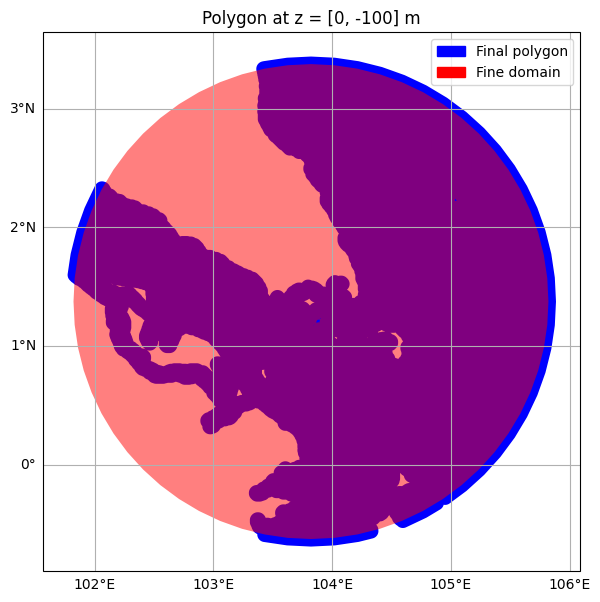

In [9]:
import geopandas as gpd
import matplotlib.patches as mpatches
import ocsmesh
from bluemath_tk.core.geo import buffer_area_for_polygon
from shapely.geometry import MultiPolygon

rasters = [ocsmesh.Raster(path) for path in clipped_raster_paths]

coarse_domain_clipped = (
    ocsmesh.Geom(rasters, zmax=Mean_Sea_Level)
    .get_multipolygon()
    .intersection(domain_polygon)
)
selected_polygon = (
    ocsmesh.Geom(rasters, zmin=Wind_effect_max_depth)
    .get_multipolygon()
    .intersection(domain_polygon)
)

envelope = selected_polygon.convex_hull
coarse_minus_envelope = coarse_domain_clipped.difference(envelope)
refined_shape = coarse_domain_clipped.difference(coarse_minus_envelope)

if isinstance(refined_shape, MultiPolygon):
    cleaned_polygon = max(refined_shape.geoms, key=lambda p: p.area)
else:
    cleaned_polygon = refined_shape

outer_buffered = buffer_area_for_polygon(polygon=cleaned_polygon, area_factor=0.5)
inner_buffered = buffer_area_for_polygon(polygon=selected_polygon, area_factor=-2)

final_polygon = outer_buffered.difference(inner_buffered)

fig, ax = plt.subplots(subplot_kw={"projection": ccrs.PlateCarree()}, figsize=figsize)
gpd.GeoSeries(final_polygon).plot(ax=ax, color="blue")
gpd.GeoSeries(selected_polygon).plot(ax=ax, color="red", alpha=0.5)

final_polygon_patch = mpatches.Patch(color="blue", label="Final polygon")
fine_domain_patch = mpatches.Patch(color="red", label="Fine domain")
ax.legend(handles=[final_polygon_patch, fine_domain_patch], loc="best")
ax.set_title(f"Polygon at z = [{Mean_Sea_Level}, {Wind_effect_max_depth}] m")
gl = ax.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False

### Grid generation

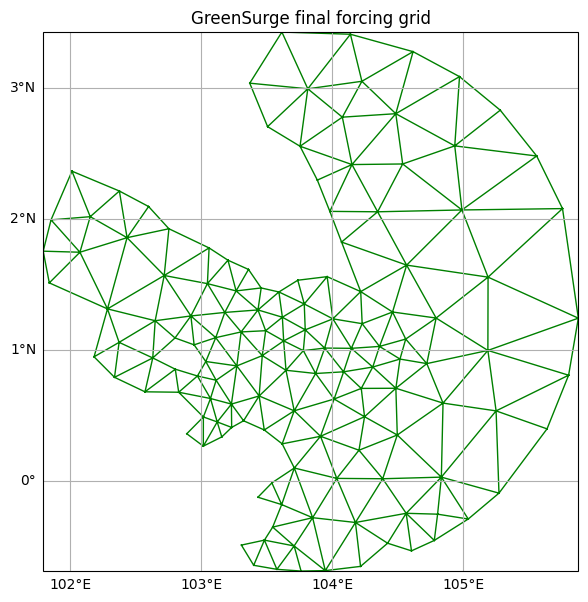

In [10]:
from bluemath_tk.topo_bathy.mesh_utils import define_mesh_target_size, plot_mesh_edge

geom_forz = ocsmesh.Geom(
    [],
    base_shape=final_polygon,
    base_shape_crs=domain_crs,
)
domain_poly = geom_forz.get_multipolygon()

depth_ranges_forcing = {
    (-200_000, -250): {"value": 100*1000, "rate":  None},
    (-10, 20): {"value": 20*1000, "rate": 0.00005},
}

hfun_forz = define_mesh_target_size(
    rasters, raster_resolution_meters, depth_ranges=depth_ranges_forcing, nprocs=1
)

driver_forz = ocsmesh.JigsawDriver(
    geom=geom_forz,
    hfun=hfun_forz,
    initial_mesh=False,
)
mesh_forz = driver_forz.run()

CRS_OCS = mesh_forz.crs
to_LL = pyproj.Transformer.from_crs(CRS_OCS, "EPSG:4326", always_xy=True).transform

fig, ax = plt.subplots(subplot_kw={"projection": ccrs.PlateCarree()}, figsize=figsize)
plot_mesh_edge(mesh_forz.msh_t, to_geo=to_LL, ax=ax, color="green", lw=1)
ax.set_title("GreenSurge final forcing grid");

### Mesh saving

In [11]:
path_grd_forz = f"outputs/mesh_{site}_Viento_adcirc.grd"
mesh_forz.write(path_grd_forz, format="grd", overwrite=True)

## GreenSurge Setup Summary

### Build simulation dataset

In [12]:
from bluemath_tk.additive.greensurge import build_greensurge_infos_dataset

simulation_dataset = build_greensurge_infos_dataset(
    path_grd_calc=path_grd_calc,
    path_grd_forz=path_grd_forz,
    site=site,
    wind_speed=wind_speed,
    direction_step=direction_step,
    simulation_duration_hours=simulation_duration_hours,
    simulation_time_step_hours=simulation_time_step_hours,
    forcing_time_step=forcing_time_step,
    reference_date_dt=reference_date_dt,
    Eddy=Eddy,
    Chezy=Chezy,
)

simulation_dataset.to_netcdf(
    f"outputs/GreenSurge_{site}_info.nc",
    "w",
    "NETCDF3_CLASSIC",
    unlimited_dims="time",
)
simulation_dataset

<xarray.Dataset> Size: 19MB
Dimensions:                            (element_computation_index: 421998,
                                        triangle_forcing_nodes: 3,
                                        node_forcing_index: 137,
                                        element_forcing_index: 207,
                                        wind_direction_index: 24,
                                        time_forcing_index: 4,
                                        node_cumputation_index: 219732)
Coordinates:
  * wind_direction_index               (wind_direction_index) int64 192B 0 .....
  * time_forcing_index                 (time_forcing_index) float64 32B 0.0 ....
    node_computation_longitude         (node_cumputation_index) float64 2MB 1...
    node_computation_latitude          (node_cumputation_index) float64 2MB 1...
    triangle_nodes                     (triangle_forcing_nodes) int64 24B 0 1 2
  * node_forcing_index                 (node_forcing_index) int64 1kB 0 ... 136
  * element_forcing_index              (element_forcing_index) int64 2kB 0 .....
  * node_cumputation_index             (node_cumputation_index) int64 2MB 0 ....
  * element_computation_index          (element_computation_index) int64 3MB ...
Dimensions without coordinates: triangle_forcing_nodes
Data variables: (12/14)
    triangle_computation_connectivity  (element_computation_index, triangle_forcing_nodes) int64 10MB ...
    node_forcing_longitude             (node_forcing_index) float64 1kB 101.8...
    node_forcing_latitude              (node_forcing_index) float64 1kB 1.755...
    triangle_forcing_connectivity      (element_forcing_index, triangle_forcing_nodes) int64 5kB ...
    wind_directions                    (wind_direction_index) int64 192B 0 .....
    total_elements                     int64 8B 207
    ...                                 ...
    wind_speed                         int64 8B 40
    location_name                      <U8 32B 'Singapur'
    eddy_viscosity                     int64 8B 10
    chezy_coefficient                  int64 8B 70
    reference_date                     <U19 76B '2022-01-01 00:00:00'
    forcing_time_step                  int64 8B 1
Attributes:
    title:        Hybrid Simulation Input Dataset
    description:  Structured dataset containing simulation parameters for hyb...
    created:      2025-06-20 11:52:44
    institution:  GeoOcean
    model:        GreenSurge

### Presentation of the GFD

<div style="border: 1px solid #cce5ff; background-color: #e9f7fe; padding: 15px; border-radius: 6px; font-family: sans-serif;">
  <strong>🔹 Green Function Database (GFD)</strong><br><br>

  The first stage, the compilation of the empirical Green’s Functions Database (GFD) includes:
  <ul>
    <li>Definition of the cells for the application of the unit wind covering all possible directions established. The shape and area of these cells should be as small as possible in order to ensure the spatial characterization of any cyclone and large enough not to lose the advantage of this methodology in terms of computing performance and independence with respect to full dynamic simulations.</li>
    <li>Definition of the unit wind magnitude and the direction discretization of wind sources, as well as the drag coefficient function (function of wind magnitude).</li>
    <li>Time definition of each independent simulation corresponding to each Green’s function, both the length of the sustained unit wind (hereafter, time step) and the time afterwards at which it is necessary to record sea level response over the whole domain.</li>
    <li>Computation of the GFD with a SW numerical model.</li>
  </ul>
</div>

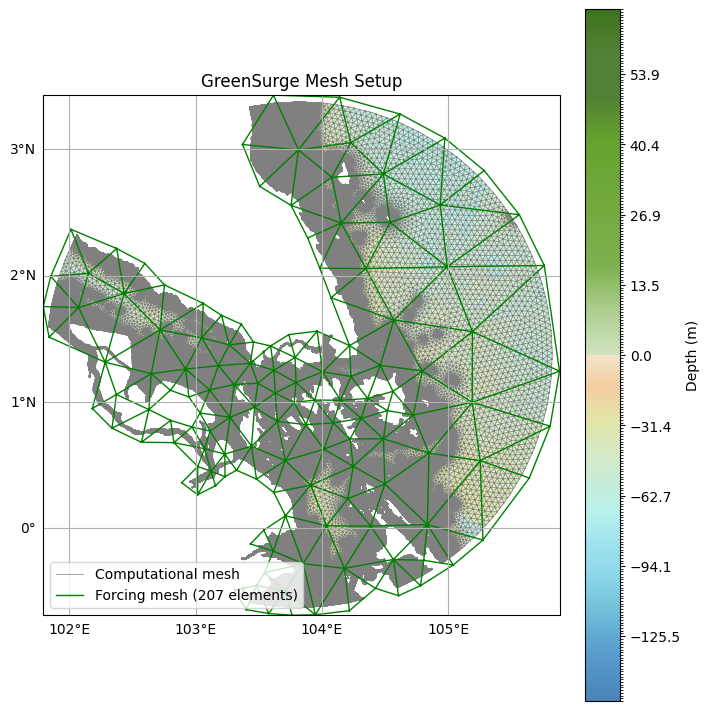

In [13]:
from bluemath_tk.additive.greensurge import plot_greensurge_setup_with_raster

plot_greensurge_setup_with_raster(
    simulation_dataset=simulation_dataset, path_grd_calc=path_grd_calc, figsize=figsize
)